<a href="https://colab.research.google.com/github/NaasikJahan/AsrSystem/blob/main/AsrSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install SpeechRecognition librosa tensorflow nltk

In [2]:
# Import libraries
import speech_recognition as sr
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import get_custom_objects
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from google.colab import files
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [3]:
# Download NLTK data packages
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
#  activation function
def relu(x):
    return tf.maximum(0.1 * x, x)

tf.keras.utils.get_custom_objects().update({'relu': tf.keras.layers.Activation(relu)})

In [5]:
# Function to upload audio file
def upload_audio():
    uploaded = files.upload()
    for fn in uploaded.keys():
        print(f'User uploaded file "{fn}"')
        return fn

In [6]:
# Upload the audio file
audio_path = upload_audio()

Saving Speaker26_003.wav to Speaker26_003 (2).wav
User uploaded file "Speaker26_003 (2).wav"


In [7]:
# Initialize recognizer
recognizer = sr.Recognizer()

In [8]:
# Load the uploaded audio file
audio_file = sr.AudioFile(audio_path)

with audio_file as source:
    audio_data = recognizer.record(source)

In [9]:
# Initialize recognizer
recognizer = sr.Recognizer()

In [10]:
# Recognize speech using Google Web Speech API
try:
    text = recognizer.recognize_google(audio_data)
    print("Recognized text:", text)
except sr.UnknownValueError:
    print("Google Web Speech API could not understand the audio")
except sr.RequestError as e:
    print(f"Could not request results from Google Web Speech API; {e}")

Recognized text: the chickens will become ready for Market wind poultry will fetch the highest price so that by the end of the year I shall have money enough to buy a new gown in this dress I will go to the Christmas junkies when all the young fellows will propose to me but I will toss my head and refuse them everyone at this moment she tossed her head in unison with her thoughts went down fill the milk pot to the ground and broke into 100 pieces and all her friends period they are hatched the man and woman of Alliance One very cold winter day yesterday inquiring the reason he told him that he did it to warm his hands


In [11]:
#  Feature Extraction
def extract_features(file_path):
    y, sr = librosa.load(file_path)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Extract Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Extract Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # Extract Tonnetz Features
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

    # Extract additional features
    zcr = librosa.feature.zero_crossing_rate(y)
    rmse = librosa.feature.rms(y=y)

    # Aggregate features
    features = np.hstack([
        np.mean(mfccs.T, axis=0),
        np.mean(chroma.T, axis=0),
        np.mean(contrast.T, axis=0),
        np.mean(tonnetz.T, axis=0),
        np.mean(zcr.T, axis=0),
        np.mean(rmse.T, axis=0)
    ])

    return features

features = extract_features(audio_path)

In [12]:
#  Data Augmentation
def augment_audio(file_path):
    y, sr = librosa.load(file_path)

    # Time-stretching
    y_stretch = librosa.effects.time_stretch(y, rate=0.8)

    # Pitch-shifting
    y_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=4)

    return y_stretch, y_shift

y_stretch, y_shift = augment_audio(audio_path)

In [13]:
def create_cnn_rnn_model(input_shape):
    model = Sequential([
        tf.keras.layers.Reshape((input_shape, 1), input_shape=(input_shape,)),
        tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        # tf.keras.layers.Flatten(),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_rnn_model = create_cnn_rnn_model(features.shape[0])

In [14]:
# Dummy training data for demonstration
X_train = np.random.randn(100, features.shape[0])
y_train = np.random.randint(2, size=100)

In [15]:
# Training Loop
def training_loop(model, X_train, y_train, epochs, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for step, (x_batch, y_batch) in enumerate(dataset):
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = loss_fn(y_batch, predictions)
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            if step % 100 == 0:
                print(f"Step {step}: loss = {loss.numpy()}")

cnn_rnn_model = create_cnn_rnn_model(features.shape[0])

# Pass the model object to the training loop
training_loop(cnn_rnn_model, X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
Step 0: loss = 0.6930961608886719
Epoch 2/10
Step 0: loss = 0.690356969833374
Epoch 3/10
Step 0: loss = 0.6933292150497437
Epoch 4/10
Step 0: loss = 0.6988178491592407
Epoch 5/10
Step 0: loss = 0.7004507780075073
Epoch 6/10
Step 0: loss = 0.6979836225509644
Epoch 7/10
Step 0: loss = 0.6944400668144226
Epoch 8/10
Step 0: loss = 0.6928723454475403
Epoch 9/10
Step 0: loss = 0.6955450177192688
Epoch 10/10
Step 0: loss = 0.7040035128593445


In [16]:
# NLP Post-Processing with NLTK
tokens = word_tokenize(text)
tagged = pos_tag(tokens)

print("Tokenized and POS tagged text:", tagged)

Tokenized and POS tagged text: [('the', 'DT'), ('chickens', 'NNS'), ('will', 'MD'), ('become', 'VB'), ('ready', 'JJ'), ('for', 'IN'), ('Market', 'NNP'), ('wind', 'NN'), ('poultry', 'NN'), ('will', 'MD'), ('fetch', 'VB'), ('the', 'DT'), ('highest', 'JJS'), ('price', 'NN'), ('so', 'RB'), ('that', 'IN'), ('by', 'IN'), ('the', 'DT'), ('end', 'NN'), ('of', 'IN'), ('the', 'DT'), ('year', 'NN'), ('I', 'PRP'), ('shall', 'MD'), ('have', 'VB'), ('money', 'NN'), ('enough', 'NN'), ('to', 'TO'), ('buy', 'VB'), ('a', 'DT'), ('new', 'JJ'), ('gown', 'NN'), ('in', 'IN'), ('this', 'DT'), ('dress', 'NN'), ('I', 'PRP'), ('will', 'MD'), ('go', 'VB'), ('to', 'TO'), ('the', 'DT'), ('Christmas', 'NNP'), ('junkies', 'NNS'), ('when', 'WRB'), ('all', 'PDT'), ('the', 'DT'), ('young', 'JJ'), ('fellows', 'NNS'), ('will', 'MD'), ('propose', 'VB'), ('to', 'TO'), ('me', 'PRP'), ('but', 'CC'), ('I', 'PRP'), ('will', 'MD'), ('toss', 'VB'), ('my', 'PRP$'), ('head', 'NN'), ('and', 'CC'), ('refuse', 'VB'), ('them', 'PRP'),

In [17]:
#  Evaluation Metrics
def evaluation(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    return precision, recall, f1

In [18]:
# Example evaluation (using dummy data)
true_labels = np.random.randint(2, size=100)
predicted_labels = np.random.randint(2, size=100)

precision, recall, f1 = evaluation(true_labels, predicted_labels)
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Precision: 0.5217391304347826, Recall: 0.48, F1 Score: 0.4999999999999999


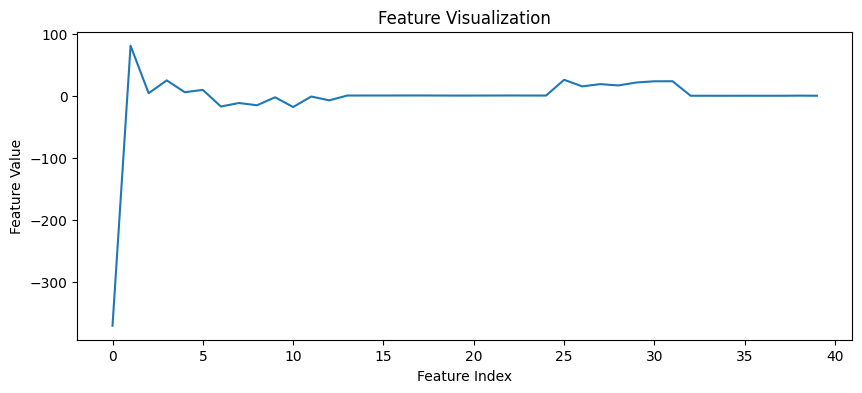

In [19]:
#  Visualization Tools
def visualize_features(features):
    plt.figure(figsize=(10, 4))
    plt.plot(features)
    plt.title("Feature Visualization")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.show()

visualize_features(features)